http://nlp.seas.harvard.edu/annotated-transformer/

The Transformer has been on a lot of people's minds over the last five years. This post presents an annotated version of the paper in the form of a line by line implementation.  It reorders and deletes some sections from the original paper and adds comments throughout. This document itself is a working notebook, and should be a completely usable implementation.

##Table of Contents


###prelims

###Background

###Part 1 : Model Architecture

### Model Architecture
- Encoder and Decoder Stacks
- Position-wise FFN
- Embeddings and Softmax
- Positional Encoding
- Full Model
- Inference :

### Part 2 : Model Training
Training
- Batches and Masking
- Training Loop
- Training Data and Batching
- Hardware and Schedule
- Optmizer
- Regularization

### First Example
- Synthetic Data
- Loss Computation
- Greedy Decoding

### Part 3  : Real World Example
- Data Loading
- Iterators
- Training the System

### Additional Components : BPE, Search, Averaging

### Results
- Attention Visualization
- Encoder Self Attention
- Decoder Self Attention
- Decoder Src Attention

### Conclusion



#Prelims

In [ ]:
# !pip install -r requirements.txt

In [ ]:
# # Uncomment for colab
# #
# !pip install -q torchdata ==0.3.0 torchtext==0.12 spacy == 3.2 altair GUPtil
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm



In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time

from torch.optim.lr_scheduler import LambdaLR

import pandas as pd
import altair as alt

from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets import datasets
import spacy
import GUPtil

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data.distributed import DistributedSampler
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataPalallel as DDP

RUN_EXAMPLES = True

In [ ]:
# Some convenience helper functions used throughout the notebook

def is_interactive_notebook() :
  return __name__=='__main__'

def show_example(fn, args=[]) :
  if __name__ == '__main__' and RUN_EXAMPLES :
    return fn(*args)

def excute_example(fn, args=[]) :
  if __name__ == '__main__' and RUN_EXAMPLES :
    return fn(*args)

class DummyOptimizer(torch.optim.OPtimizer) :
  def __init__(self) :
    self.param_groups = [{'lr' : 0}]
    None
  
  def step(self) :
    None
  
  def zero_grad(self, set_to_none = False) :
    None
  

class DummyScheduler :
  def step(self) :
    None

## Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convoulistional neural networkds as basic building block, computing hidden representations in parallel for all input and output positions. In these models, #operations required to relate signals from two arbitrary input or output positions grows in the distance btw positions, linearly for convS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies btw distant postions. In the Transformer, this is ***reduced to a constant number of operations***, albeit at the cost of reduces effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, texual entailment and learning task-independent sentence representations. End-to-end memory networkds are based on a recurrent attention mechanism instead of sequencealigned resurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and ouput without using sequence aligned RNNs or convolution.

# Part 1  : Model Architecture

## Model Architecture

Most competitive neural sequence transduction models have an encoder-decoder structure.

Here, the encoder maps an input sequence of symbl representations(x1,...,xn) to a sequence of continuous representation z=(z1,....,zn). Given z, the decoder then generates an output sequence(y1,....,ym) of symbols one element at a time. At each step the model is auto-regressive, consuming the previously generated symbols as additional input when generating the next.

In [ ]:
class EncoderDecoder(nn.Module) :
  '''
  A Standard Encoder-Decoder architecture. Base for this and many other models.
  '''

  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator) :
    super(EncdoerDecoder,self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self. src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask) :
    'Take in and process masked src and target sequences'
    return self.decode(self.encode(src,src_mask), src_mask, tgt, tgt_mask)

  def encode(self, src, src_mask) :
    return self.encoder(self.src_embed(src), src_mask)

  def decode(self, memory, src_mask, tgt, tgt_mask) :
    return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module) :
  'Define standard linear + softmax Generation step'

  def __init__(self, d_model, vocab) :
    super(Generator,self).__init__()
    self.proj = nn.Linear(d_model. vocab)

  def forward(self,x) :
    return log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self_attention and point-wise, FC layers for both the encoder and decoder, sown in the left and right halves of Figure 1, respectively.

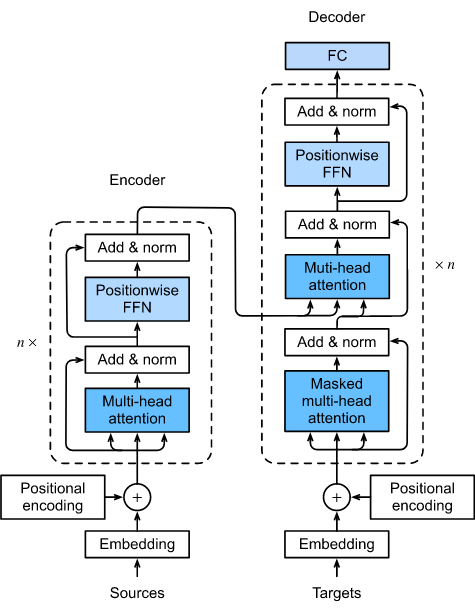()

# Encoder and Encoder Stacks



## Encoder

The encoder is composed of a stack of ***N = 6*** identical layers

In [ ]:
def clones(module, N) :
  'produce N identical layers'
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module) :
  'core encoder is a stack of N layers'

  def __init__(self, layer, N) :
    super(Encoder,self).__init__()
    self.layers = clones(layer,N)
    self.norm = LayerNorm(layer.size)

  def forward(self,x,mask) :
    'pass the input through each layer in turn'

    for layer in self.layers :
      x = layer(x, mask)
    
    return self.norm(x)

We employ a residual connection around each of the two sub-layers, followed by layer normalization

In [ ]:
class LayerNorm(nn.Module) :
  'Construct a layernorm module'

  def __init__(self, features, eps=1e-6) :
    super(LayerNorm, self).__init__()

    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self,x) :
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x-mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is LayerNorm(x + sublayer(x)), where sublayer(X) is the function implemented by the sub-layer itself. We apply dropout to the output ea each sub-layer, before it is added to the sublayer input and normalized.

To faciliate these residual connections, all sublayers in the model, as well as the embedding layers, produce outputs of dim d_model = 512.

In [ ]:
class SublayerConnection(nn.Module) :
  '''
  A residual connection followed by a layer norm.
  Note for code simplicity the norm is first as oppsed to last.
  '''

  def __init__(self, size, dropout) :
    super(Sublayerconnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  
  def forward(self,x,sublayer) :
    'Apply residual connection to any sublayer with the same size'
    return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layes. The first is a multihead self attention mechanism, and the 2nd is a simple, position-wise FC FFN.

In [ ]:
class EncoderLayer(nn.Module) :
  'Encoder is made up to self-attn and ff'

  def __init__(self, size, self_attn, ff, dropout) :
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.ff = ff
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask) :
    'Follow Figure 1(left) for connections'
    x = self.sublayer[0](x, lambda x : self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.ff)

## Decoder

The Decoder is also composed of a stack of N = 6 identical layers.

In [ ]:
class Decoder(nn.Module) :
  'Generic N layer decoder with masking'

  def __init__(self, layer, N) :
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)

  def forward(self, x, memory, src_mask, tgt_mask) :
    for layer in self.layers :
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sublayer, which performs multi head attn over the output of the enoder stack.

Similar to the encoder, we employ residual connections around each of the sublayers, followed by layer normalization

In [ ]:
class DecoderLayer(nn.Module) :
  'Decoder is made of self_attn, src_attn, and ff'

  def __init__(self, size, self_attn, src_attn, ff, dropout) :
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.ff = ff
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  
  def forward(self, x, memory, src_mask, tgt_mask) :
    'Follow figure 1(right) for connections'
    m = memory

    x = self.sublayer[0](x, lambda x : self.self_attm(x,x,x, tgt_mask))
    x = self.sublayer[1] (x, lambda x : self.src_attn(x,m,m, src_mask))

    return self.sublayer[2](x, self.ff)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This amsking, combined with fact that the output embeddings are offset by one position, ensure that the predictions for position i can depend only on the known outputs at positions less than i.

In [ ]:
def subsequent_mask(size) :
  'Mask out subsequent positions'

  attn_shape = (1, size, size)
  subsequent_mask = torch.triu(torch.ones(attn_shape), disgonal=1).type(torch.unit8)

  return subsequent_mask == 0

Below the attn mask shows tha position each tgt word(row) is allowed to look at (column). Words are blocked for attending to future words during training.

In [ ]:
def example_mask() :
  LS_data = pd.concat(
      [
          pd.DataFrame(
              {'Subsequent Mask' : subsequent_mask(20)[0][x,y].flatten(),
               'Window' : y,
               'Masking' : x
               }
          )
          for y in range(20) :
       for x in range(20)
      ]
  )

  return ( 
      alt.Chart(LS_data).mark_rect().properties(height=250, width=250)
      .encode(
          alt.X('window:0'),
          alt.Y('Masking:0'),
          alt.Color('Subseuquent Mask : Q', scale=alt.Scale(scheme='viridis')),
      ),
      interactive()
      
  )

show_example(example_mask)

# Attention

An attention fuction can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and outputs are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention 'Scaled Dot Product Attention'. The input consists of queries and keys of dim d_k, and values fo dim d_v. 

We compute the dot products of the query with all keys, divide each by l(d_k) and apply a softmax function to obtain the weights on the values.

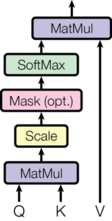

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V. We compute the matrix of outputs as :

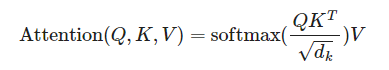

In [ ]:
def attention(query, key, value, mask = None, dropout= None) :
"Compute 'Scaled dot product attention'"

  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)
  if mask is not None :
    socres = socres.masked_fill(mask == 0, -1e9)

  p_attn = scores.softmax(dim=-1)

  if dropout is not None :
    p_attn = dropout(p_attn)
  
  return torch.matmul(p_attn, value), p_attn

The two most commonly used attnetion fuctions are additive attention, and dot product(multiplicative) attnetion.

Dot product attention is identical to out algorithm, except for the scaling factor of 1/sqrt(d_k). Additive attention computes the compatibility funcion using a FFN with a single hidden layer. While the two are similar in theoretical complexity, dot product attention is much faster and more space efficient in practice, since it can be implemented using highly optimized matrix multiplication code.

While for small values of d_k, the two mechanisms perform similarly, additive attention outperforms dor product attention without scaling for larger values of d_k.

We suspect that for large values fo d_k, the dot products grow large in magnutude, pushing the softmax fuction into regions where it has extreamly small gradients ( To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product, q.k = sigma(d_k, i=1) * q_i*k_i, has mean 0 and variance d_k). To counteract this effect, we scale the dot products by 1/sqrt(d_k)





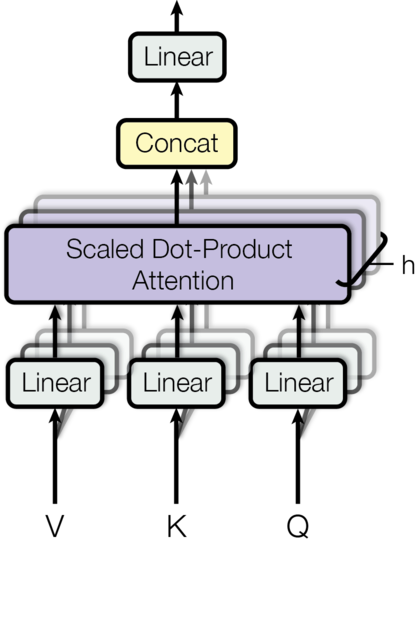

Multi head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.



In this work we emply h=8 parallel attention layers, or heads. For each of these we use d_k = d_v = d_model . h =64.

Due to the reduced dimention of each head, the total computational cost is similar to that of single head attnetion with full dimensionality

In [ ]:
class MultiHeadedAttention(nn.Module) :
  def __init__(self, h, d_model, dropout = 0.1) :
    'Take in model size and number of heads'

    super(MultiHeadedAttnetion, self).__init__()

    assert d_moel % h == 0
    # We assume d_v always euqals d_k

    self.d_k = d_model  //h 
    self. h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self. dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None) :
    'Implements Figure 2'

    if mask is not None :
      # same mask applied to all h heads.
      mask = mask.unsqueeze(1)
    
    nbatches = query.size(0)

    # 1) Do all the linear projections in batch from d_model
    query, key, value = [
        lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1,2)
        for lin, x in zip(self.linears, (quiry, key, value))
    ]

    # 2) Apply attention on all the projected vectors in batch.

    x, self.attn = attention(
        query, key, value, mask=mask, dropout=self.dropout
    )

    # 3) 'concat' using a view and apply a final linear

    x = (
        x.transpose(1,2)
        .contiguous()
        .view(nbatches, -1, self.h * self.d_k)
    )

    del query
    del key
    del value
    return self.linear[-1](x)

## Applications of Attention in out Model

The Transformer uses multi-head attention in three different ways :

1. Encoder decoder attention layers
- the queries come from the prev decoder laer, and the memory keys and values come from the output of the encoder. This allows every position in the decoder to attend over all positions in the input sequence. This mimics the typical encoder-decoder attention mechanisms in sequence to sequence model,

2. self-attention layers
- layers all of the keys, values and queries come from the same place, in this case, the output of the previous layer in the encoder. Each position in the encoder can attent to all positions in the previous layer of the encoder.

3. decoder in self-attnetion layers
- each position in the decoder to attend to all positions in the decoder up to and including that position. We need to prevent leftward information flow in the decoder to preserve the auto-regressive property. We implement this inside of scaled dot-product attention by masking out all values in the input of the softmax which correspond to illegal connections.

# Position-wise FFN

In addition to attention sublayers, each of the layers in our encoder and decoder contains a FC FFN, which is applied to each position separately and identically. This consists of two lienar transformations with a ReLU activation in btw.



FFN(x) = max(0,x*W1 + b1)*W2 + b2

while the linear transformations are the same across different positions, they use different parameters from layer to layer.

Another way of describing this is a s two convolutions with kernel size1. The dimensionality of input and ouput is d_model = 512, and the inner-layer has dimensiionality dff=2048.

In [ ]:
class PositionwisFeedForward(nn.Module) :
  'Implements FFN equation'

  def __init__(self, d_model, d_ff, dropout=0.1) :
    super(PositionwiseFeedForward,self).__init__()
    self.w_1 = nn.Linear(d_model, d_ff)
    self.w_2 = nn,Linear(d_ff, d_model)
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x) :
    return self.w_2(self.dropout(self.w_1(x).relu()))

#Embeddings and Softmax

Similarly to other sequence transduction models, we use learned embeddings to convert the input tokens and output tokens to vectors of dimension d_model. We also use the usual learned linear transformation and sofrmax function to convert the decoder output to predicted next-token probabilities.

In out model, we share the same weight atrix btw the two embedding layers and the pre softmax linear transfomration.

In the embedding layers, we multiply those weghts by sqrt(d_model.

In [ ]:
class Embedding(nn.Module) :
  def __init__(self, d_model, vocab) :
    super(Embedding, self).__init__()
    self.lut = nn.Embedding(vocab, d_model)
    self.d_model = d_model

  def forward(self, x) :
    return self.lut(x) * math.sqrt(self.d_model)

#Positional Encoding

since out model contains no recurrence and no convolution, in order for the model to make use of the order of the sequence, we must inject some information abourt the relative or absolute position of the tokens in the sequence.

To this end, we add 'positional encodings' to the input embeddings at the bottms of the encoder and decoder stacks.

The positional encodings have the same dimension d_model as the embeddings, so that the two can be summed. There are amny choices of positional encoding,s learned and xied.

In this work, we use sine and cosine functions of different frequencies :

*PE(pos,2i) = sin(pos/10000^(2i/d_model)*

*PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model)*

where *pos* is the position and i is the dimension. That is, each dimension of the positional encording corresponds to a sinusoid. The wavelengths form a geometric progression from 2pie to 10000 * 2pie.

We chose this function because we hypothesized it would allow the model to easily learn to attend by relative postiions, since for any fixed offset k, Pe_pos+k can be represented as a linear function of Pe_pos.

In addition, we apply dropout to the sums of the embeddings and the positional encodings in both and encoder and decoder stakcs. For the base model, we use a rate of p_drop = 0.1







In [ ]:
class PositionalEncoding(nn.Module) :

  def __init__(self, d_model, dropout, max_len=5000) :
    super(PositionalEncoding,self).__init__()
    self.dropout = nn.Dropout(p=dropout)

    # Conpute the positional encodings once in log space

    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)

    div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x) :
    x = x + self.pe[:, : x.size(1)].requires_grad_(False)
    return self.dropout(x)

In [ ]:
def example_positional() :
  pe = PositionalEncoding(20,0)

  y = pe.forward(torch.zeros(1,100,20))

  data = pd.concat(
    [
      pd.DataFrame(
          {
              'embedding' : y[0, : , dim],
           'dimension' : dim,
           'position' : list(range(100))
          }
      )
      for dim in [4,5,6,7]
    ] 
  )

  return (
      alt.Chart(data)
      .mark_line()
      .properties(width=100)
      .encode(x='position', y='embedding', color = 'dimension:N' )
      . interactive()
  )

show_example(example_positional)

We also experimented with using learned positional embeddings instead, and found that the two versions produces nearly identical results.

We chose the sinusoidal version because it may allow the model to extrapolate to sequence lengths longer than the ones encountered duting training.

#Full model

In [ ]:
def make_model(
  src_vocab, tgt_vocab, n=6, d_model = 512, d_ff = 2048, h=8, dropout=0.1
)

  'construct a model from hyperparameters'

  c = copy.deepcopy
  attn = MultiHeadedAttention(h,d_model)
  ff = PositionwiseFeedForward(d_model, d_ff, dropout)
  position = PositionalEncoding(d_model, dropout)

  model = EncoderDecoder(
      Encoder(EncdoerLayer(d_model, c(attn), c(ff), dropout),N,
              Decoder(DecoderLayer(d_model, c(attn), c(ff), dropout),N),
              nn.Sequential(Embeddings(d_model,, src_vocav), c(position)),
              nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
              Generator(d_model, tgt_vocab))
  )

  #This was important from their code,
  # initialize parameters with glorot /  fan_avg,

  for p in model.parameters() :
    if p.dim() > 1:
      nn.init.xavier_uniform(p)
    return model

#Inference

Here we make a forward step to generate a prediction of the model. We try to use our transformer to memorize the input. As you will see the output is randomly generated due to the fact that the model is not trained yet. In the next, we will build the training function and try to train our model to memorize the numbers from 1 to 10.

In [ ]:
def inferece_test() :
  test_model = make_model(11,11,2)
  test_model.eval()
  src = torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]])
  src_mask = torch.ones(1,1,10)

  memory = test_model.encode(src, src_mask)
  ys = torch.zeors(1,1).type_as(src)

  for i in range(9) :
    out = test_model.decode(
        memory, src_mask, ys, subsequent_mask(y.size(1)).type_as(src.data)
    )
    prob = test_model.generator(out[:,-1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data[0]
    ys = torch.cat(
        [ys, torch.empty(1,1).type_as(src.data).fill(next_word)], dim=1
    )

  print('Example untrained model prediction:', ys)

def run_tests() :
  for _ in range(10) :
    inference_test()

show_example(run_tests)

# Part2 : Model Training

## Training

This section describes the training regime for our model.

## Batches and masking

In [ ]:
class Batch :
  'Object for hilding a batch of data with mask during training'

  def __init__(self, src, tgt=None, pad=2) :   # 2 = blank
    self.src = src
    self.src_mask = (src != pad).unsqueeze(-2)

    if tgt is not None :
      self.tgt = tgt[:,:-1]
      self.tgt_y = tgt[:,1:]
      self.tgt_mask = self.make_std_mask(self.tgt, pad)
      self.ntokens = (self.tgt_y != pad).data.sum()

    
  @staticmethod
  def make_std_mask(tgt, pad) :
    'create a mask to hide padding and future words'
    tgt_mask = (tgt != pad).unsqueeze(-2)
    tgt_mask = tgt_mask & subsequenct_mask(tgt.size(-1)).type_as(tgt_mask.data)

    return tgt_mask


##Training Loop

In [ ]:
class TrainState :
  'Track # steps, examples, and tokens processed'

  step : int = 0
  accum_step : int = 0
  samples : int = 0
  tokens : int = 0

In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode='train',
    accum_iter=1,
    train_state = TrainState()
) :

  'Train a single epoch'
  start = tiem.time()
  total_tokens = 0
  totla_loss = 0
  tokens = 0
  n_accum = 0

  for i, batch in enumerate(data_iter) :
    out = model.forward(batch.src, batch.tgt, batch.src_mas, batch.tgt_mask)
    loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)

    # loss_node = loss_node / accum_iter
    if mode == 'train' or mode == ' train+log' :
      loss_node.backward()
      train_state.step +=1
      train_state.tokens += batch.tokens
      train_state.samples += batch.src.shape[0]

      if i % accum_iter == 0 :
        optimizer.step()
        optimizer.zero_grad(set_to_none= True)
        n_accum +=1 
        train_state.accum_step +=1 
      scheduler.step()

    totla_loss += loss
    total_tokens += batch.ntokens
    tokens += batch.ntokens

    if i % 40 == 1 and (mode =='train' or mode == 'train+log') :
      lr =  optimizer.param_groups[0]['lr']
      elapsed = time.time() - start
      print(
          ( 'epoch step : %d | accumulation step : %3d | loss : %6.2f' + '| tokens / sec : %7.1f | Learning rate : %6.1e')
      
      )
      % (i, n_accum, loss / batch.ntokens, tokens / elased , lr)
      )
      start = time.time()
      tokens = 0
    
    del loss
    del loss_node
  return total_loss / total_tokens, train_state

## Training Data and Batching

We trained on the standard WMT 2014 English German dataset consisting of abour 4.5 mil sentence apris. Sentences were encoded using byte-pair encoding, which has a shared source-target vocabulary of about 37000 tokens.

Sentence pairs were batched together by approximate sequence length. Each training batch contrained a se of sentence pairs containing approxiamtely 25000 source tokens and 25000 target tokens.

## Optimizer

We used the Adam optimizer with b1=0.9, b2=0.98 and eps = 1e-9.

lrate = d_model ^-0.5 * min(step_num^-0.5, step_num * warmup_steps^-1.5)

This corresponds to increasing the learning rate lienarly for the first warmup_steps training steps, and decreasing it thereafter proportionally to the inverse square root of the step number. We used warmup_steps = 4000

In [ ]:
def rate(stpe, model_size, factor, warmup) :
  """ we have to default the step to 1 for lambdaR function to avoid
  zero raising to negative power.
  """
  if step == 0 :
    step =1
  return factor * (model_size ** (-0.5) * min(step**(-1.5),step * warmup ** (-1.5)))

In [ ]:
def example_learning_schedule() :
  opts = [
      [512,1,4000],
      [512,1,8000],
      [256,1,4000
  ]

  dummy_model = torch.nn.Linear(1,1)
  learning_rates = []

  # we have 3 examples in opts list

  for idx, example in enumerate(opts) :
    optimizer = torch.optim.Adam(
        dummy_model.parameters(), lr=1, betas=O(0.9,0.89), eps=1e-9
    )
    lr_scheduler = LambdaR(optimizer=optimizer, lr_lambda = lambda step : rate(step, *example)
    tmp = []
    
    # take 20k dummy training step, save the learning rate at each step
    for step in range(20000) :
      tmp.append(optimizer.param_groups[0]['lr'])
      optimizer.step()
      lr.scheduler.step()
    learning_rates.append(tmp)

  learning_rates = torch.tensor(learning_rates)

  #Enable altair to handle more than 5000 rows

  alt.data_transformers.disable_max_rows()

  opts_data = pd.concat(
      [
          pd.DataFrame({
              'learning_rate' : learning_rates[warmup_idx, :],
              'model_size : warmup' : ['512:4000','512:8000','256:4000'][warmup_idx],
              'step' : range(20000)
                                 }     
          )
          for warmup_idx in [0,1,2]
      ]
  )
  return (
      alt.Chart(opts_data)
      .mark_line()
      .properties(width=500)
      .encode(x='step', y='lr', color='model_size : warmup:N')
      .interactive()
  )


example_learning_schedule()

## Retularization



### LAbel Smoothing

during training, we emplyed label smoothing of value eps_ls = 0.1.

This hurts perplexity, as the model learns to be more unsure, but improbes accuracy and BLEU score.

In [ ]:
class LableSmoothing(nn.Module) :
  'Implement label smoothing'

  def __init__(self, size, padding_idx, smoothing = 0) :
    super(LabelSmoothing,self).__init__()
    self.criterion = nn.KLDivLoss(reduction='sum')
    self.padding_idx = padding)idx
    self.confidence = 1.0-smoothing
    self.smoothing = smoothing
    self.size = size
    self.true_dist = None

  def forward(self,x, target) :
    assert x.size(1) == self.size
    true_dist = x.data.clone()
    true_dist.fill(self.smoothing / (self.size-2))
    true_dist.scatter_(1, target.data.unseqeeze(1), self.confidence)
    true_dist[:, self.padding_idx] = 0
    mask = torch.nonzero(target.data == self.padding_idx)

    if mask.dim() > 0 :
      true_dist.index_fill_(0, mask.squeeze(),0,0)
    
    self.true_dist = true_dist
    return self,criterion(x, true_dist.clone().detach())


In [ ]:
def example_label_smoothing() :
  crit = LabelSmoothing(5,0,0.4)
  predict = torch.FloatTensor(
      [
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],
        [0, 0.2, 0.7, 0.1, 0],  
      ]
  )
  crit(x=predict.log(), target=torch.LongTensor([2,1,0,3,3]))
  Ls_data = pd.concat(
    [
        pd.DataFrame({
            'target dist' : crit.true_dist[x,y].flatten(),
            'columns' : y,
            'rows' : x}
        )
        for x in range(5)
        for y in range(5)
        ]
  )

  return (
    alt.Chart(LS_data)
    .mark_rect(color='blue', opacity = 1)
    properties(height=200, width=200)
    .encode(
        alt.X('columns:0' , title=None),
        alt.Y('rows:0', title=None),
        alt.Color(
          'Target dis : q', scale = alt.Scale(scheme='viridis')
  )
    )
    .interactive()
  )

show_example(example_label_smoothing)

In [ ]:
def loss(x,crit) :
  d = x + 3 *1
  predict = torch.FloatTensor([[0,x /d, 1/d , 1/d, 1/d]])
  return crit(predict.log(), torch.LongTensor([1])).data

def penalization_visualization() :
  crit = LabelSmoothing(5,0,0.1)
  loss_data = pd.DataFrame(
      {
          'loss' : [loss(x,crit) for x in range(1,100)],
          'steps' : list(range(100))      }
  ).astype('float')

  return (
    alt.Chart(loss_data)
    .mark_line()
    .properties(width=500)
    .encode(
        x='steps',
        y='loss'
    )
    .interactive(
  )

show_examples(penalization_visualization)